In [1]:
# Common stuff reused by all applications
from analysis_common import *
%matplotlib inline


EXPERIMENT_SIZE_FIELDS = [
    "number_of_fragments",
    "points_per_fragment", 
]

PLATFORM_FIELDS = [
    "nodes",
    "cpus_per_node",
    "backends_per_node",
    "dataclay",
    "use_split",
]

HANDPICKED_OUTLIERS = []

In [2]:
db = DataStorage("histogram-split")
df = prepare_df(db, HANDPICKED_OUTLIERS)

# Comment those lines to evaluate the active vs non-active
#df.query("use_active == 1 or dataclay == 0", inplace=True)
#del df['use_active']

In [3]:
edf = df.explode("iteration_time").sort_values('mode')
edf['iteration_time'] = edf['iteration_time'].astype(float)
winsorize_edf(edf, "iteration_time", ["mode", "nodes","points_per_fragment", "number_of_fragments"])

/home/alex/BSC/split-miniapps/analysis/analysis_common.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_df[mask] = mstats.winsorize(working_df[mask], limits=[0, 0.1])


# Weak scaling (small blocks)

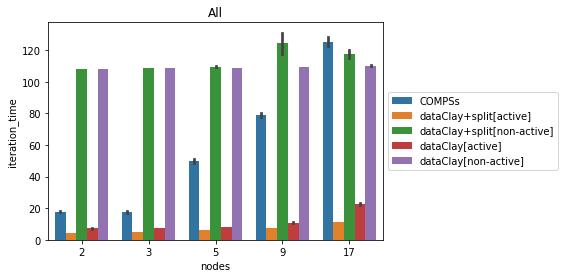

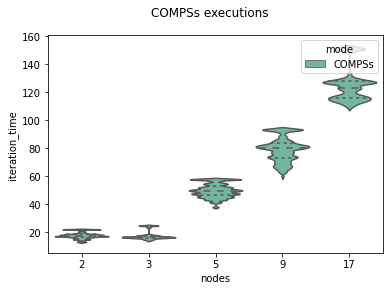

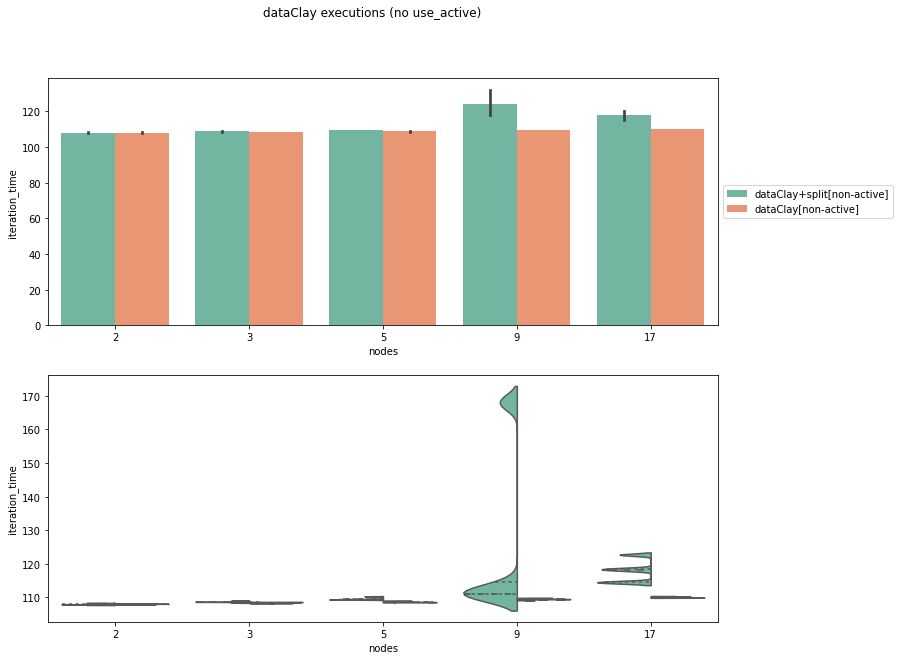

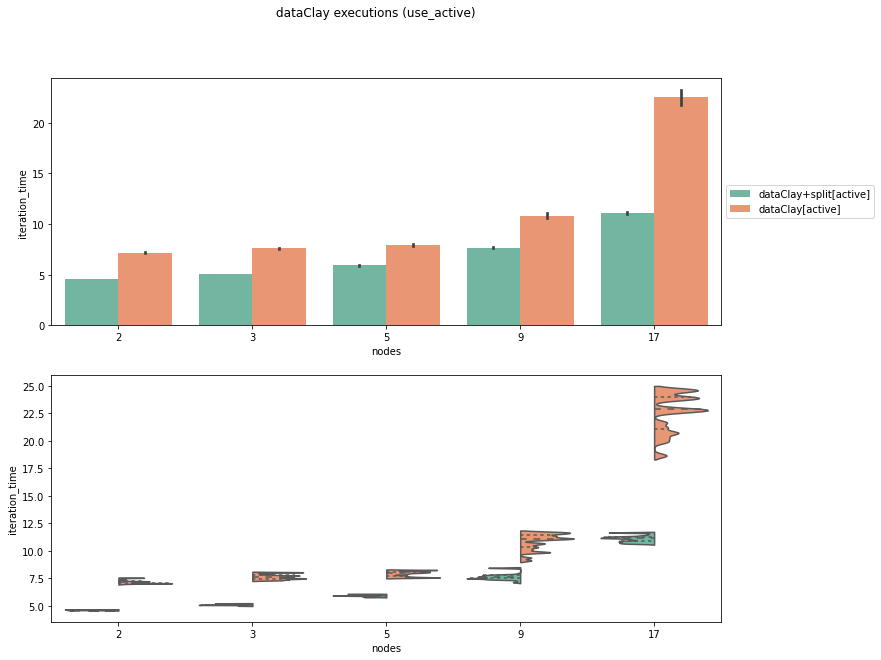

initialization_time  iteration_time
nodes mode                                                           
2     COMPSs                                23.308485       17.840527
      dataClay+split[active]                64.612378        4.611061
      dataClay+split[non-active]            63.542299      108.033526
      dataClay[active]                      63.931954        7.175148
      dataClay[non-active]                  64.149714      108.063854
3     COMPSs                                24.804294       17.653428
      dataClay+split[active]                77.608615        5.088196
      dataClay+split[non-active]            77.747184      108.721511
      dataClay[active]                      77.832155        7.624541
      dataClay[non-active]                  77.782943      108.463187
5     COMPSs                                25.205500       49.713327
      dataClay+split[active]               138.540755        5.910426
      dataClay+split[non-active]           139.260780      109.558865
      dataClay[active]                     138.494650        7.896922
      dataClay[non-active]                 139.457374      108.692527
9     COMPSs                                27.423961       79.052112
      dataClay+split[active]               269.777711        7.661485
      dataClay+split[non-active]           273.072889      124.364452
      dataClay[active]                     272.046878       10.836524
      dataClay[non-active]                 269.249399      109.525752
17    COMPSs                                49.679546      125.181436
      dataClay+split[active]               545.071353       11.091513
      dataClay+split[non-active]           539.953140      117.678446
      dataClay[active]                     552.626036       22.530845
      dataClay[non-active]                 542.901173      110.100197

In [4]:
# Weak scaling
data = edf.query("((number_of_fragments / (nodes - 1)) == 2304) and (points_per_fragment == 384000)")
small_blocks_data = data.copy()
small_blocks_data["nodes"] -= 1

plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

# Weak scaling (big blocks)

- 48 fragments **per node**
- Blocks are big

This experiment has the same size as the previous one. 

This is a bad scenario for the split; data is perfectly balanced, so there is no real benefit of doing a split. Because the job load is high, the overhead may not be extremely big.

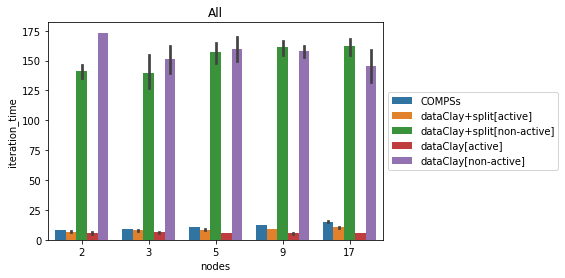

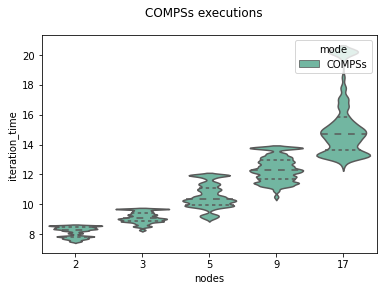

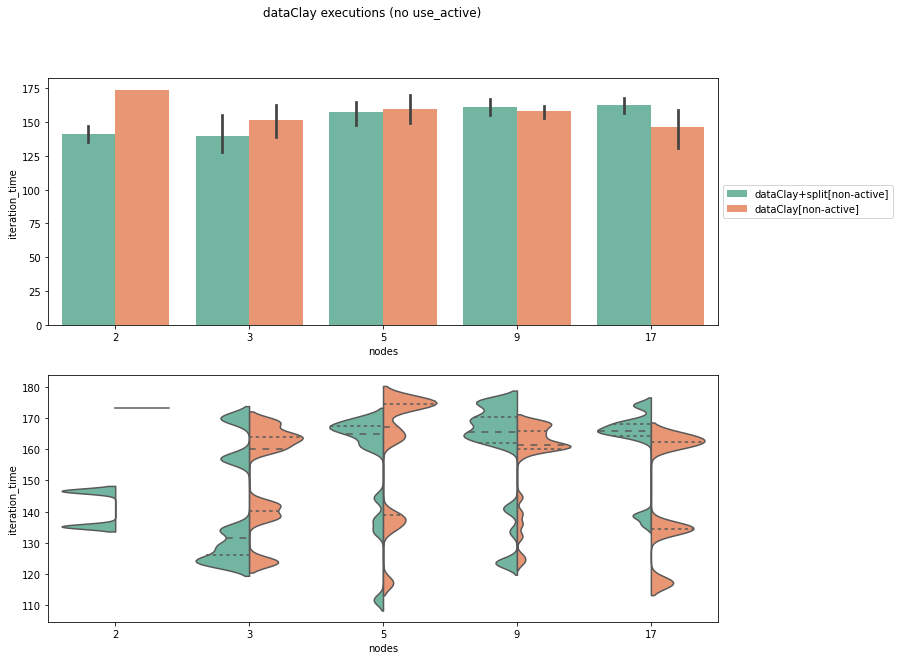

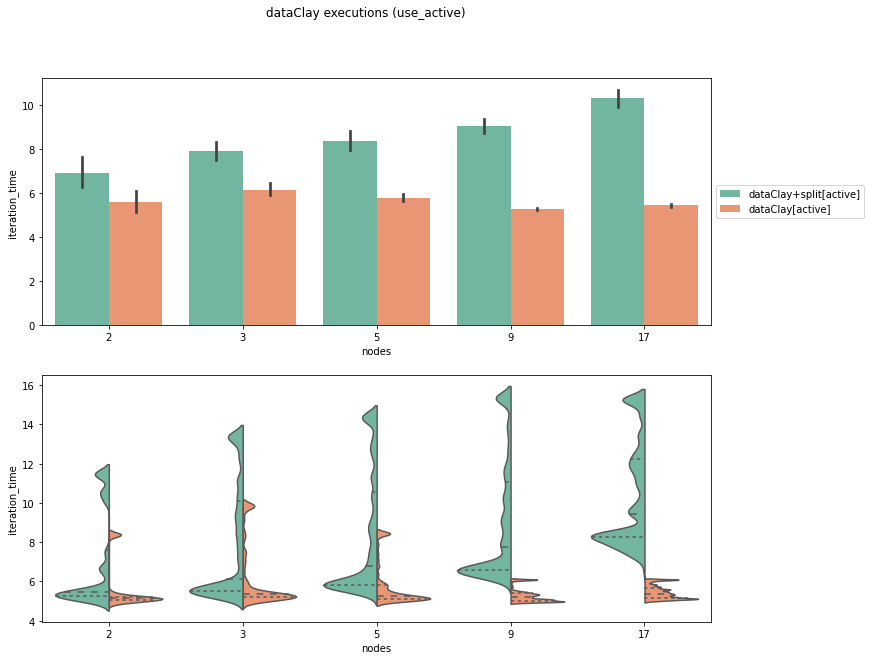

initialization_time  iteration_time
nodes mode                                                           
2     COMPSs                                20.023207        8.160478
      dataClay+split[active]                81.500582        6.928112
      dataClay+split[non-active]            93.800591      140.913167
      dataClay[active]                      80.434805        5.606534
      dataClay[non-active]                  77.977902      173.320262
3     COMPSs                                19.534909        9.122438
      dataClay+split[active]                93.085764        7.920258
      dataClay+split[non-active]            95.448967      139.705339
      dataClay[active]                      91.997959        6.156996
      dataClay[non-active]                  94.416105      151.556138
5     COMPSs                                20.647594       10.533370
      dataClay+split[active]               148.747607        8.371382
      dataClay+split[non-active]           146.430803      156.815687
      dataClay[active]                     148.521050        5.788190
      dataClay[non-active]                 148.196946      159.444402
9     COMPSs                                21.718569       12.366220
      dataClay+split[active]               272.480837        9.023596
      dataClay+split[non-active]           271.453197      161.026420
      dataClay[active]                     273.093921        5.274116
      dataClay[non-active]                 272.125938      157.671034
17    COMPSs                                25.610025       15.290628
      dataClay+split[active]               524.350941       10.296019
      dataClay+split[non-active]           525.536410      162.048630
      dataClay[active]                     524.059702        5.446029
      dataClay[non-active]                 524.985667      145.834786

In [5]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("((number_of_fragments / (nodes - 1)) == 48) and ((points_per_fragment) == (18432000))")
big_blocks_data = data.copy()
big_blocks_data["nodes"] -= 1

plot_things(data, "iteration_time")

data = data.drop(data.columns.difference(["nodes", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["nodes", "mode"]).mean()

## Blocksize sweep

8 worker nodes, analyze multiple block sizes (from 128000 points per block to 48 blocks per node). Those are the scenarios of weak scaling (see previous experiments).

In [6]:
# Weak scaling, with big blocks (48 blocks per node)
data = edf.query("(nodes == 9) and ((number_of_fragments * points_per_fragment) == (18432000 * 48 * 8))")

def eval_granularity_index(row):
    row["granularity_index"] = row["number_of_fragments"] // (48 * 8)
    return row

data = data.apply(eval_granularity_index, axis=1)
sweep_data = data.copy()

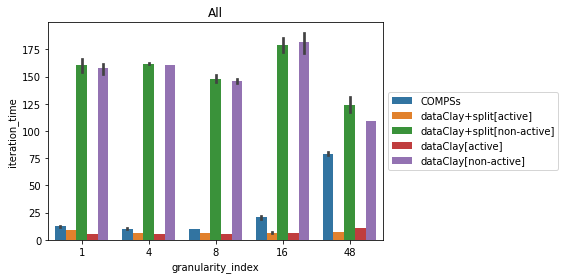

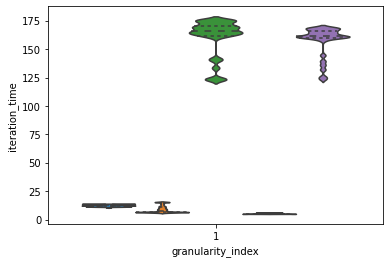

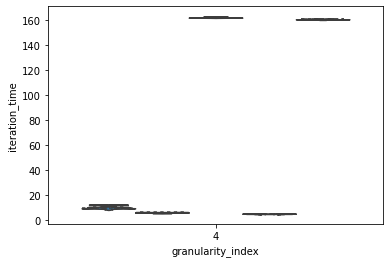

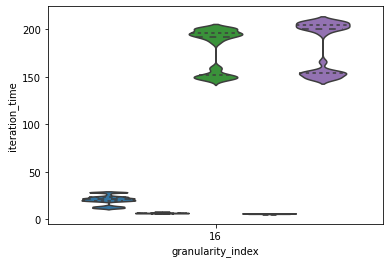

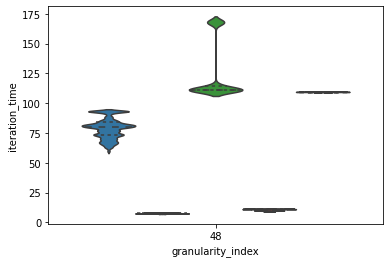

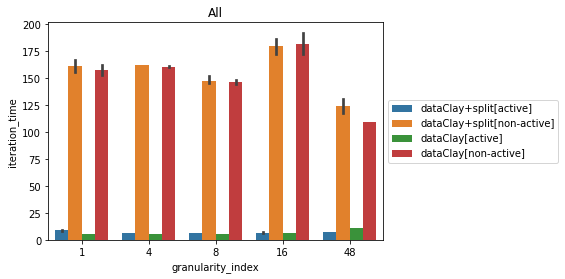

initialization_time  \
granularity_index mode                                              
1                 COMPSs                                21.718569   
                  dataClay+split[active]               272.480837   
                  dataClay+split[non-active]           271.453197   
                  dataClay[active]                     273.093921   
                  dataClay[non-active]                 272.125938   
4                 COMPSs                                23.870955   
                  dataClay+split[active]               266.307981   
                  dataClay+split[non-active]           263.351565   
                  dataClay[active]                     266.926050   
                  dataClay[non-active]                 266.124325   
8                 COMPSs                                20.230018   
                  dataClay+split[active]               264.889100   
                  dataClay+split[non-active]           266.358040   
                  dataClay[active]                     266.909585   
                  dataClay[non-active]                 263.010085   
16                COMPSs                                22.492419   
                  dataClay+split[active]               266.797096   
                  dataClay+split[non-active]           264.640519   
                  dataClay[active]                     265.562902   
                  dataClay[non-active]                 265.733278   
48                COMPSs                                27.423961   
                  dataClay+split[active]               269.777711   
                  dataClay+split[non-active]           273.072889   
                  dataClay[active]                     272.046878   
                  dataClay[non-active]                 269.249399   

                                              iteration_time  
granularity_index mode                                        
1                 COMPSs                           12.366220  
                  dataClay+split[active]            9.023596  
                  dataClay+split[non-active]      161.026420  
                  dataClay[active]                  5.274116  
                  dataClay[non-active]            157.671034  
4                 COMPSs                           10.426930  
                  dataClay+split[active]            6.304188  
                  dataClay+split[non-active]      161.967449  
                  dataClay[active]                  5.228568  
                  dataClay[non-active]            160.485718  
8                 COMPSs                           10.008099  
                  dataClay+split[active]            6.074606  
                  dataClay+split[non-active]      147.499932  
                  dataClay[active]                  5.280744  
                  dataClay[non-active]            146.303239  
16                COMPSs                           20.586573  
                  dataClay+split[active]            6.777537  
                  dataClay+split[non-active]      179.226702  
                  dataClay[active]                  6.088091  
                  dataClay[non-active]            181.744515  
48                COMPSs                           79.052112  
                  dataClay+split[active]            7.661485  
                  dataClay+split[non-active]      124.364452  
                  dataClay[active]                 10.836524  
                  dataClay[non-active]            109.525752

In [7]:
sns.barplot(data=data, x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
# TODO: Change granularity_index to: fragments per core [o algo així]
plt.show()

for i in [1, 4, 16, 48]:
    ax = sns.violinplot(data=data.query("granularity_index == %d" % i),
                        x="granularity_index", hue="mode", y="iteration_time", 
                        scale='width', bw=VIOLIN_BW,
                        inner="quartile", figsize=123)
    ax.get_legend().remove()
    plt.show()

sns.barplot(data=data.query("dataclay == 1"), x="granularity_index", hue="mode", y="iteration_time", 
            estimator=ESTIMATOR_TO_USE)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title("All")
plt.show()

data = data.drop(data.columns.difference(["granularity_index", "mode", "initialization_time","iteration_time"]), axis="columns")
data.groupby(["granularity_index", "mode"]).mean()


# Figure generation

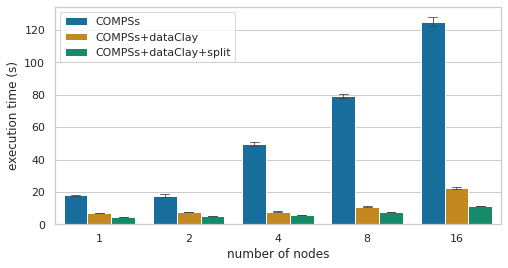

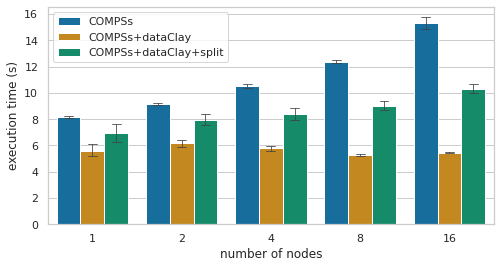

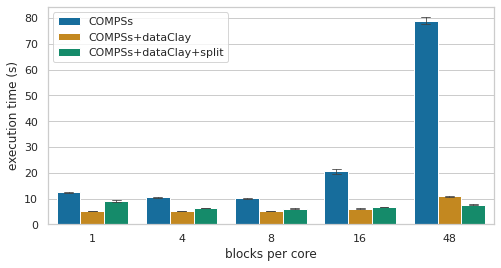

In [8]:
sns.set(style="whitegrid", color_codes=True)

hue_order=["COMPSs", "dataClay[active]", "dataClay+split[active]"]

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=small_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("histogram-weakscaling_smallblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("histogram-weakscaling_bigblocks.pdf")
plt.show()

ax = sns.barplot(y="iteration_time", x="granularity_index", hue="mode",
                 data=sweep_data,
                 capsize=0.1,
                 errwidth=0.8,
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs+dataClay", "COMPSs+dataClay+split"])
ax.set_ylabel("execution time (s)")
ax.set_xlabel("blocks per core")

save_tweaks("histogram-blocksweep.pdf")
plt.show()


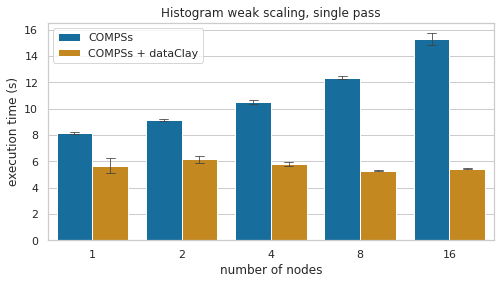

In [9]:
hue_order=["COMPSs", "dataClay[active]"]

ax = sns.barplot(y="iteration_time", x="nodes", hue="mode",
                 data=big_blocks_data,
                 capsize=0.1,
                 errwidth=0.8,
                 hue_order=hue_order,
                 palette="colorblind")

h, l = ax.get_legend_handles_labels()
ax.legend(h, ["COMPSs", "COMPSs + dataClay"])
ax.set_title("Histogram weak scaling, single pass")
ax.set_ylabel("execution time (s)")
ax.set_xlabel("number of nodes")

save_tweaks("histogram-anotherpresentation.png")
plt.show()
